In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly.subplots as sp
import pytz
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

In [2]:

RESPECK_FILE = '../data/bishkek_csr/03_train_ready/respeck/26-04-2025_respeck.csv'
PSG_FILE = '../data/bishkek_csr/03_train_ready/nasal_files/26-04-2025_nasal.csv'
LABELS_FILE = '../data/bishkek_csr/03_train_ready/event_exports/26-04-2025_event_export.csv'

respeck_df = pd.read_csv(RESPECK_FILE)
respeck_df['timestamp'] = pd.to_datetime(respeck_df['alignedTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
respeck_df['timestamp'] = respeck_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
respeck_df.set_index('timestamp', inplace=True)

print(respeck_df.head())

psg_df = pd.read_csv(PSG_FILE)
psg_df['timestamp'] = pd.to_datetime(psg_df['UnixTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
psg_df['timestamp'] = psg_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
psg_df.set_index('timestamp', inplace=True)

labels_df = pd.read_csv(LABELS_FILE)
labels_df['timestamp'] = pd.to_datetime(labels_df['UnixTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
labels_df['timestamp'] = labels_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
labels_df.set_index('timestamp', inplace=True)

                                  alignedTimestamp  \
timestamp                                            
2025-04-26 00:00:54.037000+06:00      1.745604e+12   
2025-04-26 00:00:54.117000+06:00      1.745604e+12   
2025-04-26 00:00:54.197000+06:00      1.745604e+12   
2025-04-26 00:00:54.277000+06:00      1.745604e+12   
2025-04-26 00:00:54.357000+06:00      1.745604e+12   

                                  interpolatedPhoneTimestamp  \
timestamp                                                      
2025-04-26 00:00:54.037000+06:00               1745603999307   
2025-04-26 00:00:54.117000+06:00               1745603999387   
2025-04-26 00:00:54.197000+06:00               1745603999467   
2025-04-26 00:00:54.277000+06:00               1745603999547   
2025-04-26 00:00:54.357000+06:00               1745603999627   

                                  respeckTimestamp  sequenceNumber         x  \
timestamp                                                                      
2025-04-26 0

In [3]:
cuh = labels_df[labels_df['Event'] == 'Obstructive Apnea']['Duration']
print(cuh)

timestamp
2025-04-26 01:40:20+06:00    13,4
2025-04-26 01:44:54+06:00    12,8
Name: Duration, dtype: object


In [4]:
# Hypoapnea: A reduction in airflow of at least 30% for more than 10 seconds, accompanied by at least 4% oxygen desaturation or A reduction in airflow of at least 30% for more than 10 seconds, associated with either at least 3% oxygen desaturation or an arousal from sleep on EEG (recommended AASM criteria)
# Apnea: A drop in the peak signal excursion by more than or equal to 90% of the pre-event baseline flow. Duration of 10 seconds or longer.
# Obstructive sleep apnea: If an increased effort is present throughout the entire apnea.

Starting apnea analysis...
Respeck data shape: (432384, 11)
Labels data shape: (796, 7)
Analysis parameters: baseline=60s, event=10s
Valid breathing signal points: 429077
Breathing signal range: -20.670145 to 23.952986
Found 2 'Obstructive Apnea' events

Validating events against breathing signal...
Processing event 1/2: 2025-04-26 01:40:20+06:00
  Baseline: 0.126107, Event: 0.101156, Change: -19.8%
Processing event 2/2: 2025-04-26 01:44:54+06:00
  Baseline: 0.173608, Event: 0.114615, Change: -34.0%

VALIDATION SUMMARY STATISTICS
Total events analyzed: 2
Valid apnea events (>=90% drop): 0
Valid rise events (>=90% rise): 0
Moderate drops (50-89%): 0
Moderate rises (50-89%): 0
Insufficient data: 0
Baseline too low: 0
No significant change: 2

Validation rate: 0.0%

Change type distribution:
  no_significant_change: 2 (100.0%)

Detailed results (first 10 events):
               event_time  baseline_amplitude  event_amplitude percent_change  is_valid_event           change_type  data_point

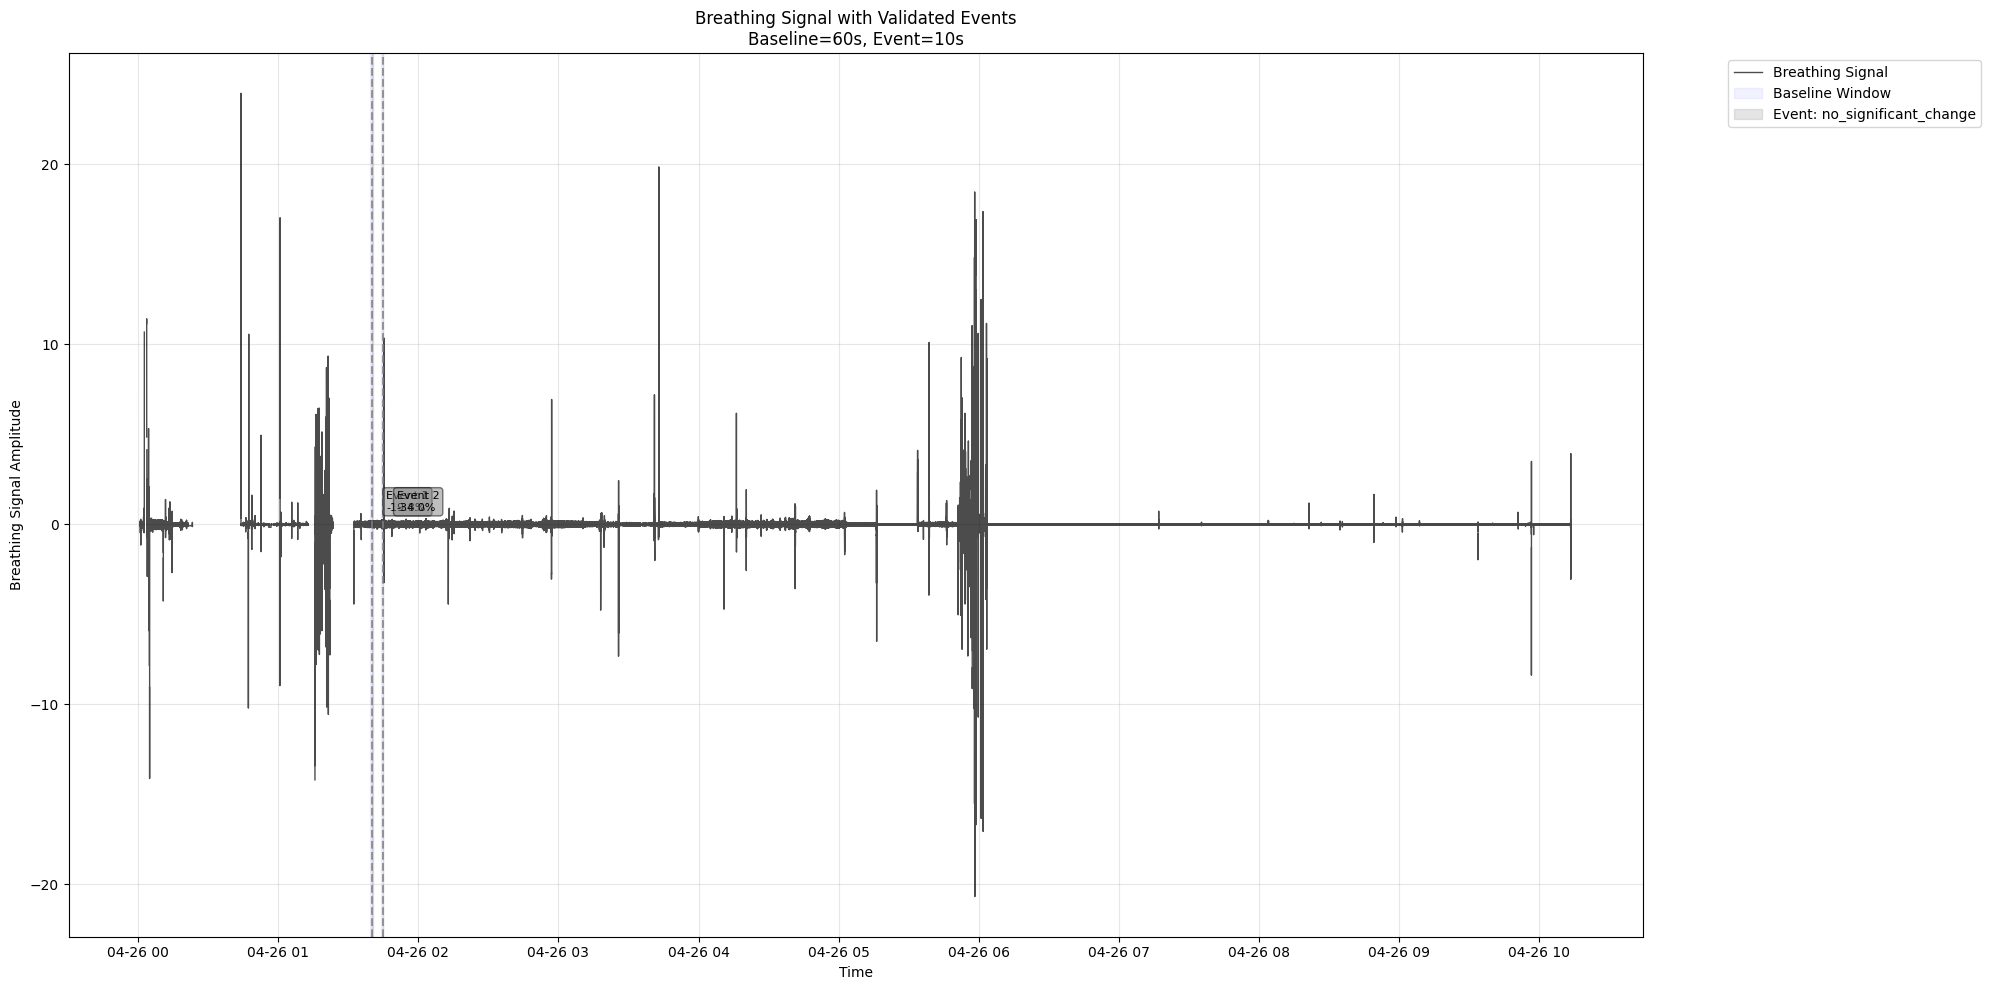

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.subplots as sp
import pytz
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, hilbert
from scipy.ndimage import uniform_filter1d

# --- Analysis Constants ---
BASELINE_DURATION_SEC = 60
EVENT_DURATION_SEC = 10

def calculate_peak_excursion(signal_segment, method='peak_to_trough'):
    """
    Calculate peak excursion (amplitude) of breathing signal.
    
    Parameters:
    -----------
    signal_segment : pd.Series
        Segment of breathing signal
    method : str
        'peak_to_trough': difference between peaks and troughs
        'envelope': using Hilbert transform envelope
        'std': standard deviation as amplitude proxy
    
    Returns:
    --------
    float : Peak excursion amplitude
    """
    if signal_segment.empty or len(signal_segment) < 10:
        return 0.0
    
    # Remove NaN values
    clean_signal = signal_segment.dropna()
    if len(clean_signal) < 10:
        return 0.0
    
    if method == 'envelope':
        # Use Hilbert transform to get amplitude envelope
        try:
            analytic_signal = hilbert(clean_signal.values)
            envelope = np.abs(analytic_signal)
            return np.mean(envelope)
        except:
            method = 'peak_to_trough'  # Fallback
    
    if method == 'peak_to_trough':
        # Find peaks and troughs
        signal_values = clean_signal.values
        
        # Normalize signal for peak detection
        signal_norm = (signal_values - np.mean(signal_values)) / (np.std(signal_values) + 1e-8)
        
        # Find peaks with adaptive prominence
        prominence_threshold = np.std(signal_norm) * 0.5
        peaks, _ = find_peaks(signal_norm, prominence=prominence_threshold, distance=5)
        troughs, _ = find_peaks(-signal_norm, prominence=prominence_threshold, distance=5)
        
        if len(peaks) == 0 or len(troughs) == 0:
            # Fallback to standard deviation
            return np.std(signal_values)
        
        # Calculate mean peak-to-trough amplitude
        peak_values = signal_values[peaks]
        trough_values = signal_values[troughs]
        amplitude = np.mean(peak_values) - np.mean(trough_values)
        return abs(amplitude)
    
    elif method == 'std':
        return np.std(clean_signal.values)
    
    return 0.0

def validate_events_vs_breathing(breathing_df, events, baseline_duration, event_duration):
    """
    Validate apnea events against breathing signal criteria.
    
    Parameters:
    -----------
    breathing_df : pd.DataFrame
        DataFrame with timestamp index and 'breathingSignal' column
    events : list
        List of event timestamps
    baseline_duration : int
        Baseline window duration in seconds
    event_duration : int
        Event window duration in seconds
    
    Returns:
    --------
    list : Validation results for each event
    """
    validation_results = []
    
    for i, event_time in enumerate(events):
        print(f"Processing event {i+1}/{len(events)}: {event_time}")
        
        # Define time windows
        baseline_start = event_time - pd.Timedelta(seconds=baseline_duration)
        baseline_end = event_time
        event_start = event_time
        event_end = event_time + pd.Timedelta(seconds=event_duration)
        
        try:
            # Extract signal segments using timestamp index
            baseline_segment = breathing_df.loc[baseline_start:baseline_end]['breathingSignal']
            event_segment = breathing_df.loc[event_start:event_end]['breathingSignal']
            
            # Check if we have enough data
            if len(baseline_segment) < 10 or len(event_segment) < 5:
                print(f"  Insufficient data: baseline={len(baseline_segment)}, event={len(event_segment)}")
                validation_results.append({
                    'event_time': event_time,
                    'baseline_amplitude': 0.0,
                    'event_amplitude': 0.0,
                    'percent_change': "N/A",
                    'is_valid_event': False,
                    'change_type': 'insufficient_data',
                    'data_points_baseline': len(baseline_segment),
                    'data_points_event': len(event_segment)
                })
                continue
            
            # Calculate amplitudes using multiple methods for robustness
            baseline_amplitude = calculate_peak_excursion(baseline_segment, method='envelope')
            event_amplitude = calculate_peak_excursion(event_segment, method='envelope')
            
            # If envelope method gives low values, try peak-to-trough
            if baseline_amplitude < 0.001:
                baseline_amplitude = calculate_peak_excursion(baseline_segment, method='peak_to_trough')
                event_amplitude = calculate_peak_excursion(event_segment, method='peak_to_trough')
            
            # Initialize validation variables
            is_valid = False
            change_type = 'no_significant_change'
            percent_change = 0.0
            
            # Check if baseline is meaningful
            if baseline_amplitude > 1e-6:  # Very small threshold
                percent_change = ((event_amplitude - baseline_amplitude) / baseline_amplitude) * 100
                
                # Check for 90% drop (apnea criteria)
                if event_amplitude <= 0.1 * baseline_amplitude:
                    is_valid = True
                    change_type = 'drop (>=90%)'
                # Check for 90% rise (unusual but possible)
                elif event_amplitude >= 1.9 * baseline_amplitude:
                    is_valid = True
                    change_type = 'rise (>=90%)'
                # Check for significant drops less than 90%
                elif event_amplitude <= 0.5 * baseline_amplitude:
                    change_type = 'drop (50-89%)'
                # Check for significant rises less than 90%
                elif event_amplitude >= 1.5 * baseline_amplitude:
                    change_type = 'rise (50-89%)'
            else:
                change_type = 'baseline_too_low'
            
            print(f"  Baseline: {baseline_amplitude:.6f}, Event: {event_amplitude:.6f}, Change: {percent_change:+.1f}%")
            
            validation_results.append({
                'event_time': event_time,
                'baseline_amplitude': round(baseline_amplitude, 6),
                'event_amplitude': round(event_amplitude, 6),
                'percent_change': f"{percent_change:+.1f}%",
                'is_valid_event': is_valid,
                'change_type': change_type,
                'data_points_baseline': len(baseline_segment),
                'data_points_event': len(event_segment)
            })
            
        except Exception as e:
            print(f"  Error processing event: {e}")
            validation_results.append({
                'event_time': event_time,
                'baseline_amplitude': 0.0,
                'event_amplitude': 0.0,
                'percent_change': "ERROR",
                'is_valid_event': False,
                'change_type': f'error: {str(e)[:50]}',
                'data_points_baseline': 0,
                'data_points_event': 0
            })
    
    return validation_results

def plot_signal_with_events(breathing_df, results, time_range=None, max_events_plot=10):
    """
    Plot breathing signal with event annotations.
    
    Parameters:
    -----------
    breathing_df : pd.DataFrame
        DataFrame with breathing signal
    results : list
        Validation results
    time_range : tuple
        (start_time, end_time) to limit plotting range
    max_events_plot : int
        Maximum number of events to plot (for performance)
    """
    plt.figure(figsize=(20, 10))
    
    # Prepare data for plotting
    plot_df = breathing_df.copy()
    if time_range:
        plot_df = plot_df.loc[time_range[0]:time_range[1]]
    
    # Plot the main signal
    plt.plot(plot_df.index, plot_df['breathingSignal'], 
             label='Breathing Signal', color='black', alpha=0.7, linewidth=1)
    
    # Plot events (limit for performance)
    events_to_plot = results[:max_events_plot] if len(results) > max_events_plot else results
    if len(results) > max_events_plot:
        print(f"Plotting first {max_events_plot} events out of {len(results)} total events")
    
    legend_labels = set()
    colors = {'drop (>=90%)': 'red', 'rise (>=90%)': 'green', 
              'drop (50-89%)': 'orange', 'rise (50-89%)': 'lightgreen'}
    
    for i, res in enumerate(events_to_plot):
        event_time = res['event_time']
        
        # Skip if event is outside plot range
        if time_range and (event_time < time_range[0] or event_time > time_range[1]):
            continue
        
        change_type = res['change_type']
        color = colors.get(change_type, 'grey')
        
        # Baseline window
        baseline_label = 'Baseline Window'
        plt.axvspan(event_time - pd.Timedelta(seconds=BASELINE_DURATION_SEC), 
                   event_time, color='blue', alpha=0.05, 
                   label=baseline_label if baseline_label not in legend_labels else "")
        legend_labels.add(baseline_label)
        
        # Event window
        event_label = f"Event: {change_type}"
        plt.axvspan(event_time, 
                   event_time + pd.Timedelta(seconds=EVENT_DURATION_SEC), 
                   color=color, alpha=0.2,
                   label=event_label if event_label not in legend_labels else "")
        legend_labels.add(event_label)
        
        # Event marker
        plt.axvline(x=event_time, color=color, linestyle='--', alpha=0.8)
        
        # Add text annotation for first few events
        if i < 5:
            plt.annotate(f'Event {i+1}\n{res["percent_change"]}', 
                        xy=(event_time, plot_df['breathingSignal'].median()),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.5),
                        fontsize=8)
    
    plt.title(f'Breathing Signal with Validated Events\n'
              f'Baseline={BASELINE_DURATION_SEC}s, Event={EVENT_DURATION_SEC}s')
    plt.xlabel('Time')
    plt.ylabel('Breathing Signal Amplitude')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()

def print_summary_statistics(validation_results):
    """Print summary statistics of the validation results."""
    if not validation_results:
        print("No validation results to summarize.")
        return
    
    df = pd.DataFrame(validation_results)
    
    print("\n" + "="*60)
    print("VALIDATION SUMMARY STATISTICS")
    print("="*60)
    
    print(f"Total events analyzed: {len(df)}")
    print(f"Valid apnea events (>=90% drop): {sum(df['change_type'] == 'drop (>=90%)')}")
    print(f"Valid rise events (>=90% rise): {sum(df['change_type'] == 'rise (>=90%)')}")
    print(f"Moderate drops (50-89%): {sum(df['change_type'] == 'drop (50-89%)')}")
    print(f"Moderate rises (50-89%): {sum(df['change_type'] == 'rise (50-89%)')}")
    print(f"Insufficient data: {sum(df['change_type'] == 'insufficient_data')}")
    print(f"Baseline too low: {sum(df['change_type'] == 'baseline_too_low')}")
    print(f"No significant change: {sum(df['change_type'] == 'no_significant_change')}")
    
    valid_events = df[df['is_valid_event'] == True]
    print(f"\nValidation rate: {len(valid_events)/len(df)*100:.1f}%")
    
    if len(valid_events) > 0:
        print(f"\nAmplitude statistics for valid events:")
        print(f"Mean baseline amplitude: {valid_events['baseline_amplitude'].mean():.6f}")
        print(f"Mean event amplitude: {valid_events['event_amplitude'].mean():.6f}")
    
    print("\nChange type distribution:")
    change_counts = df['change_type'].value_counts()
    for change_type, count in change_counts.items():
        print(f"  {change_type}: {count} ({count/len(df)*100:.1f}%)")

# ==============================================================================
# MAIN ANALYSIS SCRIPT
# ==============================================================================

def run_apnea_analysis(respeck_df, labels_df, baseline_duration=60, event_duration=10):
    """
    Main function to run the complete apnea analysis.
    
    Parameters:
    -----------
    respeck_df : pd.DataFrame
        Respeck data with timestamp index and breathingSignal column
    labels_df : pd.DataFrame  
        Labels data with Event column and timestamp index
    baseline_duration : int
        Baseline window in seconds
    event_duration : int
        Event window in seconds
    
    Returns:
    --------
    dict : Analysis results including validation_results and summary stats
    """
    global BASELINE_DURATION_SEC, EVENT_DURATION_SEC
    BASELINE_DURATION_SEC = baseline_duration
    EVENT_DURATION_SEC = event_duration
    
    print("Starting apnea analysis...")
    print(f"Respeck data shape: {respeck_df.shape}")
    print(f"Labels data shape: {labels_df.shape}")
    print(f"Analysis parameters: baseline={baseline_duration}s, event={event_duration}s")
    
    # Check data availability
    breathing_data = respeck_df['breathingSignal'].dropna()
    print(f"Valid breathing signal points: {len(breathing_data)}")
    print(f"Breathing signal range: {breathing_data.min():.6f} to {breathing_data.max():.6f}")
    
    # Extract apnea events
    apnea_events = labels_df[labels_df['Event'] == 'Obstructive Apnea'].index.tolist()
    print(f"Found {len(apnea_events)} 'Obstructive Apnea' events")
    
    if len(apnea_events) == 0:
        print("No apnea events found. Check your Event column values:")
        print(labels_df['Event'].value_counts())
        return None
    
    # Run validation
    print("\nValidating events against breathing signal...")
    validation_results = validate_events_vs_breathing(
        breathing_df=respeck_df,
        events=apnea_events,
        baseline_duration=baseline_duration,
        event_duration=event_duration
    )
    
    # Print results
    print_summary_statistics(validation_results)
    
    # Create results DataFrame
    results_df = pd.DataFrame(validation_results)
    print(f"\nDetailed results (first 10 events):")
    print(results_df.head(10).to_string(index=False))
    
    # Plot results
    print("\nGenerating visualization...")
    try:
        fig = plot_signal_with_events(respeck_df, validation_results)
        plt.show()
    except Exception as e:
        print(f"Error in plotting: {e}")
    
    return {
        'validation_results': validation_results,
        'results_df': results_df,
        'summary_stats': {
            'total_events': len(validation_results),
            'valid_events': sum(r['is_valid_event'] for r in validation_results),
            'validation_rate': sum(r['is_valid_event'] for r in validation_results) / len(validation_results) * 100
        }
    }

# Example usage:
# Assuming your data is already loaded as respeck_df and labels_df
results = run_apnea_analysis(respeck_df, labels_df, baseline_duration=60, event_duration=10)

Starting apnea analysis...
Respeck data shape: (432384, 11)
Labels data shape: (796, 7)
Analysis parameters: baseline=60s, event=10s

=== Diagnosing respeck_df ===
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index dtype: datetime64[ns, Asia/Bishkek]
Index shape: (432384,)
First few index values:
DatetimeIndex(['2025-04-26 00:00:54.037000+06:00',
               '2025-04-26 00:00:54.117000+06:00',
               '2025-04-26 00:00:54.197000+06:00'],
              dtype='datetime64[ns, Asia/Bishkek]', name='timestamp', freq=None)
Index is monotonic: True
Index is unique: True
Index value types (first 10): {<class 'pandas._libs.tslibs.timestamps.Timestamp'>}
Timezone info: Asia/Bishkek

=== Diagnosing labels_df ===
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index dtype: datetime64[ns, Asia/Bishkek]
Index shape: (796,)
First few index values:
DatetimeIndex(['2025-04-26 01:32:23+06:00', '2025-04-26 01:37:36+06:00',
               '2025-04-26 01:38:

/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_36689/3683796925.py:700: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  breathing_df['breathingSignal'] = breathing_df['breathingSignal'].fillna(method='ffill').fillna(method='bfill')


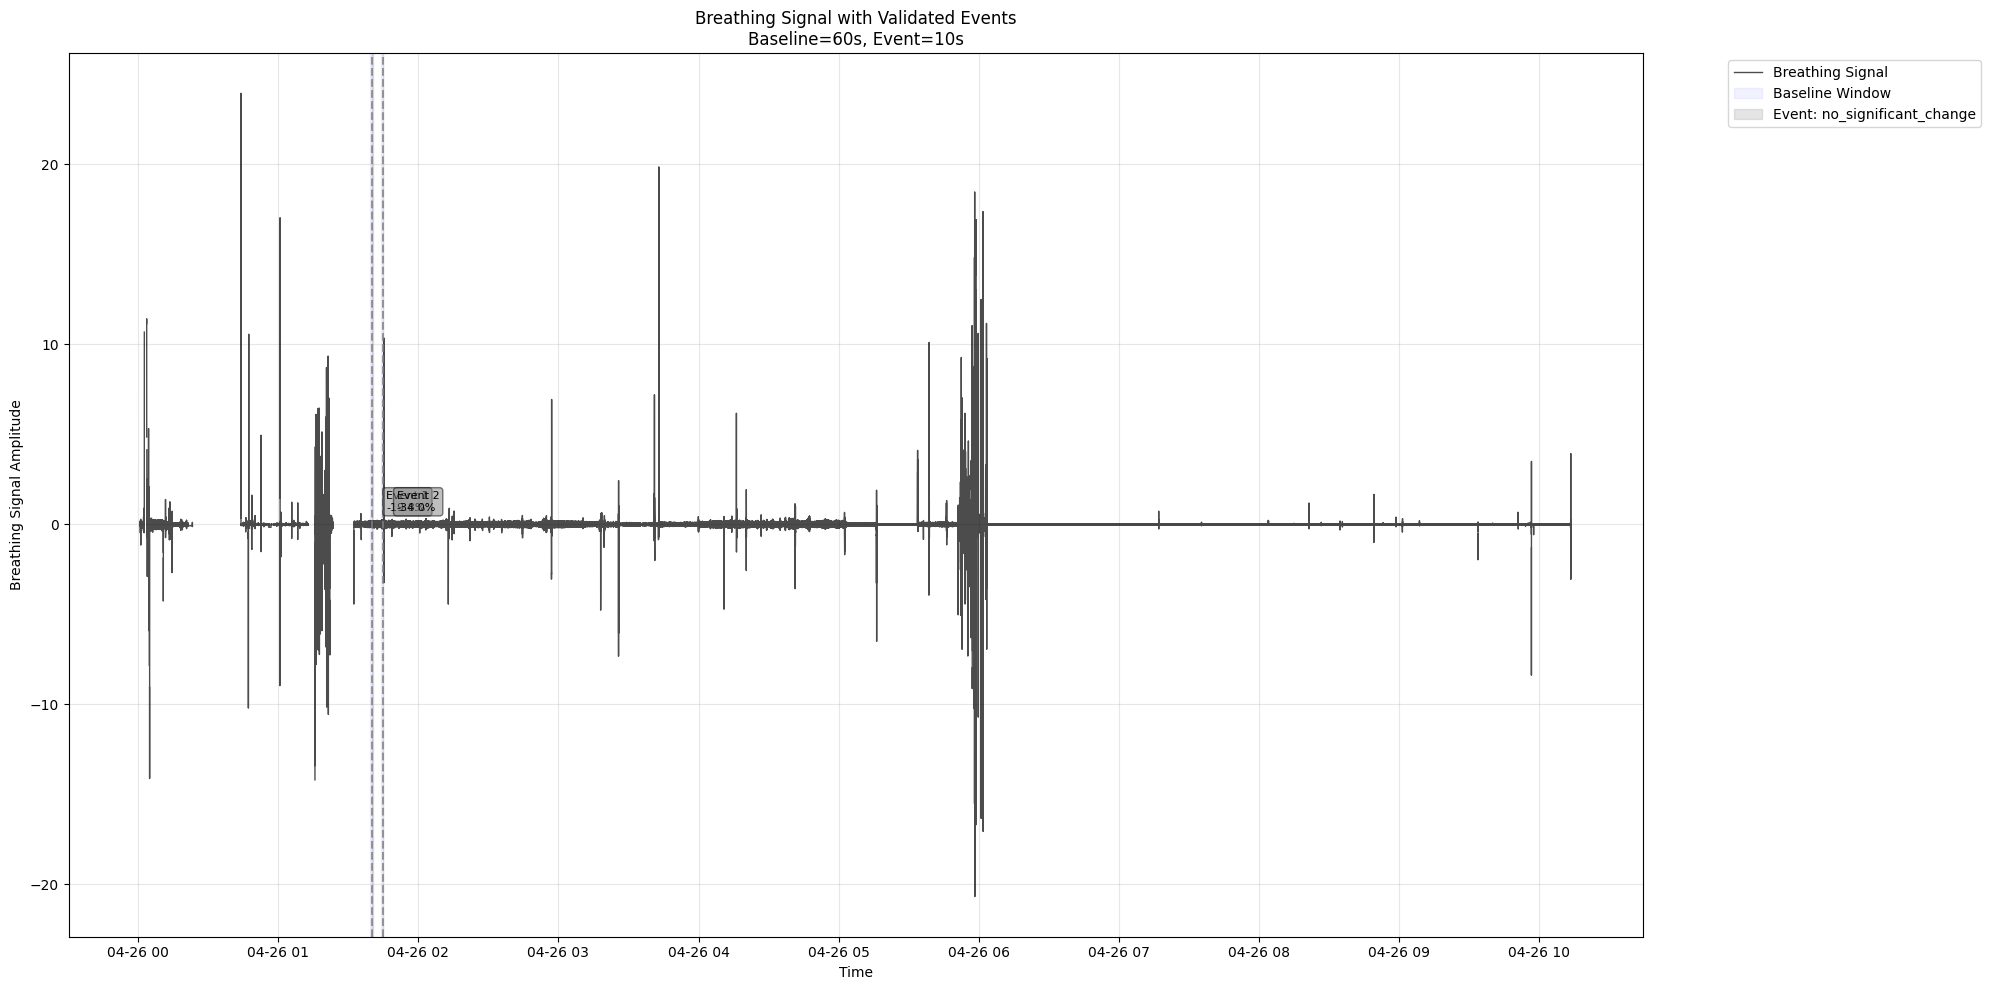

In [8]:
import pandas as pd
import plotly.graph_objects as go
import plotly.subplots as sp
import pytz
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, hilbert
from scipy.ndimage import uniform_filter1d

# --- Analysis Constants ---
BASELINE_DURATION_SEC = 60
EVENT_DURATION_SEC = 10

def calculate_peak_excursion(signal_segment, method='peak_to_trough'):
    """
    Calculate peak excursion (amplitude) of breathing signal.
    
    Parameters:
    -----------
    signal_segment : pd.Series
        Segment of breathing signal
    method : str
        'peak_to_trough': difference between peaks and troughs
        'envelope': using Hilbert transform envelope
        'std': standard deviation as amplitude proxy
    
    Returns:
    --------
    float : Peak excursion amplitude
    """
    if signal_segment.empty or len(signal_segment) < 10:
        return 0.0
    
    # Remove NaN values
    clean_signal = signal_segment.dropna()
    if len(clean_signal) < 10:
        return 0.0
    
    if method == 'envelope':
        # Use Hilbert transform to get amplitude envelope
        try:
            analytic_signal = hilbert(clean_signal.values)
            envelope = np.abs(analytic_signal)
            return np.mean(envelope)
        except:
            method = 'peak_to_trough'  # Fallback
    
    if method == 'peak_to_trough':
        # Find peaks and troughs
        signal_values = clean_signal.values
        
        # Normalize signal for peak detection
        signal_norm = (signal_values - np.mean(signal_values)) / (np.std(signal_values) + 1e-8)
        
        # Find peaks with adaptive prominence
        prominence_threshold = np.std(signal_norm) * 0.5
        peaks, _ = find_peaks(signal_norm, prominence=prominence_threshold, distance=5)
        troughs, _ = find_peaks(-signal_norm, prominence=prominence_threshold, distance=5)
        
        if len(peaks) == 0 or len(troughs) == 0:
            # Fallback to standard deviation
            return np.std(signal_values)
        
        # Calculate mean peak-to-trough amplitude
        peak_values = signal_values[peaks]
        trough_values = signal_values[troughs]
        amplitude = np.mean(peak_values) - np.mean(trough_values)
        return abs(amplitude)
    
    elif method == 'std':
        return np.std(clean_signal.values)
    
    return 0.0

def validate_events_vs_breathing(breathing_df, events, baseline_duration, event_duration):
    """
    Validate apnea events against breathing signal criteria.
    
    Parameters:
    -----------
    breathing_df : pd.DataFrame
        DataFrame with 'timestamp' column and 'breathingSignal' column
    events : list
        List of event timestamps
    baseline_duration : int
        Baseline window duration in seconds
    event_duration : int
        Event window duration in seconds
    
    Returns:
    --------
    list : Validation results for each event
    """
    validation_results = []
    
    # Check if breathing_df has timestamp as index or column
    if 'timestamp' not in breathing_df.columns and not isinstance(breathing_df.index, pd.DatetimeIndex):
        raise ValueError("breathing_df must have either 'timestamp' column or DatetimeIndex")
    
    # If timestamp is in column, set it as index temporarily
    if 'timestamp' in breathing_df.columns:
        print("Using timestamp column for indexing...")
        breathing_df = breathing_df.set_index('timestamp').sort_index()
    elif isinstance(breathing_df.index, pd.RangeIndex) and 'timestamp' not in breathing_df.columns:
        raise ValueError("breathing_df has RangeIndex but no timestamp column. Cannot match with event timestamps.")
    
    for i, event_time in enumerate(events):
        print(f"Processing event {i+1}/{len(events)}: {event_time}")
        
        # Define time windows
        baseline_start = event_time - pd.Timedelta(seconds=baseline_duration)
        baseline_end = event_time
        event_start = event_time
        event_end = event_time + pd.Timedelta(seconds=event_duration)
        
        try:
            # Extract signal segments using timestamp index
            baseline_segment = breathing_df.loc[baseline_start:baseline_end]['breathingSignal']
            event_segment = breathing_df.loc[event_start:event_end]['breathingSignal']
            
            # Debug information
            print(f"  Time windows: baseline={baseline_start} to {baseline_end}")
            print(f"  Event window: {event_start} to {event_end}")
            print(f"  Data found: baseline={len(baseline_segment)}, event={len(event_segment)}")
            
            # Check if we have enough data
            if len(baseline_segment) < 10 or len(event_segment) < 5:
                print(f"  Insufficient data: baseline={len(baseline_segment)}, event={len(event_segment)}")
                validation_results.append({
                    'event_time': event_time,
                    'baseline_amplitude': 0.0,
                    'event_amplitude': 0.0,
                    'percent_change': "N/A",
                    'is_valid_event': False,
                    'change_type': 'insufficient_data',
                    'data_points_baseline': len(baseline_segment),
                    'data_points_event': len(event_segment)
                })
                continue
            
            # Calculate amplitudes using multiple methods for robustness
            baseline_amplitude = calculate_peak_excursion(baseline_segment, method='envelope')
            event_amplitude = calculate_peak_excursion(event_segment, method='envelope')
            
            # If envelope method gives low values, try peak-to-trough
            if baseline_amplitude < 0.001:
                baseline_amplitude = calculate_peak_excursion(baseline_segment, method='peak_to_trough')
                event_amplitude = calculate_peak_excursion(event_segment, method='peak_to_trough')
            
            # Initialize validation variables
            is_valid = False
            change_type = 'no_significant_change'
            percent_change = 0.0
            
            # Check if baseline is meaningful
            if baseline_amplitude > 1e-6:  # Very small threshold
                percent_change = ((event_amplitude - baseline_amplitude) / baseline_amplitude) * 100
                
                # Check for 90% drop (apnea criteria)
                if event_amplitude <= 0.1 * baseline_amplitude:
                    is_valid = True
                    change_type = 'drop (>=90%)'
                # Check for 90% rise (unusual but possible)
                elif event_amplitude >= 1.9 * baseline_amplitude:
                    is_valid = True
                    change_type = 'rise (>=90%)'
                # Check for significant drops less than 90%
                elif event_amplitude <= 0.5 * baseline_amplitude:
                    change_type = 'drop (50-89%)'
                # Check for significant rises less than 90%
                elif event_amplitude >= 1.5 * baseline_amplitude:
                    change_type = 'rise (50-89%)'
            else:
                change_type = 'baseline_too_low'
            
            print(f"  Baseline: {baseline_amplitude:.6f}, Event: {event_amplitude:.6f}, Change: {percent_change:+.1f}%")
            
            validation_results.append({
                'event_time': event_time,
                'baseline_amplitude': round(baseline_amplitude, 6),
                'event_amplitude': round(event_amplitude, 6),
                'percent_change': f"{percent_change:+.1f}%",
                'is_valid_event': is_valid,
                'change_type': change_type,
                'data_points_baseline': len(baseline_segment),
                'data_points_event': len(event_segment)
            })
            
        except Exception as e:
            print(f"  Error processing event: {e}")
            validation_results.append({
                'event_time': event_time,
                'baseline_amplitude': 0.0,
                'event_amplitude': 0.0,
                'percent_change': "ERROR",
                'is_valid_event': False,
                'change_type': f'error: {str(e)[:50]}',
                'data_points_baseline': 0,
                'data_points_event': 0
            })
    
    return validation_results

def plot_signal_with_events_plotly(breathing_df, results, time_range=None, max_events_plot=10):
    """
    Plot breathing signal with event annotations using Plotly.
    
    Parameters:
    -----------
    breathing_df : pd.DataFrame
        DataFrame with breathing signal
    results : list
        Validation results
    time_range : tuple
        (start_time, end_time) to limit plotting range
    max_events_plot : int
        Maximum number of events to plot (for performance)
    
    Returns:
    --------
    plotly.graph_objects.Figure
    """
    # Prepare data for plotting
    plot_df = breathing_df.copy()
    if time_range:
        plot_df = plot_df.loc[time_range[0]:time_range[1]]
    
    # Create figure with subplots
    fig = sp.make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.08,
        subplot_titles=('Breathing Signal with Events', 'Event Details'),
        row_heights=[0.7, 0.3]
    )
    
    # Main breathing signal trace
    fig.add_trace(
        go.Scatter(
            x=plot_df.index,
            y=plot_df['breathingSignal'],
            name='Breathing Signal',
            line=dict(color='black', width=1),
            opacity=0.7
        ),
        row=1, col=1
    )
    
    # Plot events (limit for performance)
    events_to_plot = results[:max_events_plot] if len(results) > max_events_plot else results
    if len(results) > max_events_plot:
        print(f"Plotting first {max_events_plot} events out of {len(results)} total events")
    
    # Color mapping for different event types
    colors = {
        'drop (>=90%)': 'red',
        'rise (>=90%)': 'green', 
        'drop (50-89%)': 'orange',
        'rise (50-89%)': 'lightgreen',
        'no_significant_change': 'grey',
        'insufficient_data': 'purple',
        'baseline_too_low': 'brown'
    }
    
    # Track which legend entries we've added
    legend_added = set()
    
    # Event details for subplot 2
    event_times = []
    event_changes = []
    event_colors_list = []
    event_texts = []
    
    for i, res in enumerate(events_to_plot):
        event_time = res['event_time']
        
        # Skip if event is outside plot range
        if time_range and (event_time < time_range[0] or event_time > time_range[1]):
            continue
        
        change_type = res['change_type']
        color = colors.get(change_type, 'grey')
        
        # Baseline window rectangle
        baseline_start = event_time - pd.Timedelta(seconds=BASELINE_DURATION_SEC)
        baseline_end = event_time
        
        if 'Baseline Window' not in legend_added:
            fig.add_vrect(
                x0=baseline_start,
                x1=baseline_end,
                fillcolor="blue",
                opacity=0.1,
                layer="below",
                line_width=0,
                row=1, col=1
            )
            # Add invisible trace for legend
            fig.add_trace(
                go.Scatter(
                    x=[None], y=[None],
                    mode='markers',
                    marker=dict(color='blue', size=10),
                    name='Baseline Window',
                    showlegend=True
                ),
                row=1, col=1
            )
            legend_added.add('Baseline Window')
        else:
            fig.add_vrect(
                x0=baseline_start,
                x1=baseline_end,
                fillcolor="blue",
                opacity=0.1,
                layer="below",
                line_width=0,
                row=1, col=1
            )
        
        # Event window rectangle
        event_start = event_time
        event_end = event_time + pd.Timedelta(seconds=EVENT_DURATION_SEC)
        
        legend_name = f"Event: {change_type}"
        if legend_name not in legend_added:
            fig.add_vrect(
                x0=event_start,
                x1=event_end,
                fillcolor=color,
                opacity=0.3,
                layer="below",
                line_width=0,
                row=1, col=1
            )
            # Add invisible trace for legend
            fig.add_trace(
                go.Scatter(
                    x=[None], y=[None],
                    mode='markers',
                    marker=dict(color=color, size=10),
                    name=legend_name,
                    showlegend=True
                ),
                row=1, col=1
            )
            legend_added.add(legend_name)
        else:
            fig.add_vrect(
                x0=event_start,
                x1=event_end,
                fillcolor=color,
                opacity=0.3,
                layer="below",
                line_width=0,
                row=1, col=1
            )
        
        # Event marker line
        fig.add_vline(
            x=event_time,
            line=dict(color=color, width=2, dash="dash"),
            opacity=0.8,
            row=1, col=1
        )
        
        # Add annotation for first few events
        if i < 5:
            fig.add_annotation(
                x=event_time,
                y=plot_df['breathingSignal'].median(),
                text=f"Event {i+1}<br>{res['percent_change']}",
                showarrow=True,
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor=color,
                bgcolor=color,
                bordercolor=color,
                font=dict(color="white", size=10),
                opacity=0.8,
                row=1, col=1
            )
        
        # Collect data for subplot 2
        event_times.append(event_time)
        percent_val = res['percent_change'].replace('%', '').replace('+', '')
        try:
            event_changes.append(float(percent_val))
        except:
            event_changes.append(0)
        event_colors_list.append(color)
        event_texts.append(f"Event {i+1}: {change_type}<br>"
                          f"Change: {res['percent_change']}<br>"
                          f"Baseline: {res['baseline_amplitude']:.4f}<br>"
                          f"Event: {res['event_amplitude']:.4f}")
    
    # Add event changes bar chart in subplot 2
    if event_times:
        fig.add_trace(
            go.Bar(
                x=event_times,
                y=event_changes,
                name='Amplitude Change (%)',
                marker=dict(color=event_colors_list),
                text=event_texts,
                textposition='none',
                hovertemplate='%{text}<extra></extra>',
                showlegend=False
            ),
            row=2, col=1
        )
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=f'Breathing Signal Analysis - Apnea Event Validation<br>'
                 f'<sub>Baseline Window: {BASELINE_DURATION_SEC}s | Event Window: {EVENT_DURATION_SEC}s | '
                 f'Events Shown: {len(events_to_plot)}/{len(results)}</sub>',
            x=0.5
        ),
        height=800,
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=1.01
        ),
        hovermode='x unified'
    )
    
    # Update x and y axes
    fig.update_xaxes(title_text="Time", row=2, col=1)
    fig.update_yaxes(title_text="Breathing Signal Amplitude", row=1, col=1)
    fig.update_yaxes(title_text="Amplitude Change (%)", row=2, col=1)
    
    # Add horizontal line at -90% and +90% in subplot 2
    fig.add_hline(y=-90, line_dash="dash", line_color="red", opacity=0.5, 
                  annotation_text="90% Drop Threshold", row=2, col=1)
    fig.add_hline(y=90, line_dash="dash", line_color="green", opacity=0.5,
                  annotation_text="90% Rise Threshold", row=2, col=1)
    
    return fig

def plot_signal_with_events_simple_plotly(breathing_df, results, time_range=None, max_events_plot=10):
    """
    Simple single-panel Plotly plot of breathing signal with events.
    """
    # Prepare data for plotting
    plot_df = breathing_df.copy()
    if time_range:
        plot_df = plot_df.loc[time_range[0]:time_range[1]]
    
    # Create figure
    fig = go.Figure()
    
    # Main breathing signal trace
    fig.add_trace(
        go.Scatter(
            x=plot_df.index,
            y=plot_df['breathingSignal'],
            name='Breathing Signal',
            line=dict(color='black', width=1),
            opacity=0.7
        )
    )
    
    # Plot events (limit for performance)
    events_to_plot = results[:max_events_plot] if len(results) > max_events_plot else results
    if len(results) > max_events_plot:
        print(f"Plotting first {max_events_plot} events out of {len(results)} total events")
    
    # Color mapping
    colors = {
        'drop (>=90%)': 'red',
        'rise (>=90%)': 'green', 
        'drop (50-89%)': 'orange',
        'rise (50-89%)': 'lightgreen',
        'no_significant_change': 'grey',
        'insufficient_data': 'purple',
        'baseline_too_low': 'brown'
    }
    
    legend_added = set()
    
    for i, res in enumerate(events_to_plot):
        event_time = res['event_time']
        
        # Skip if event is outside plot range
        if time_range and (event_time < time_range[0] or event_time > time_range[1]):
            continue
        
        change_type = res['change_type']
        color = colors.get(change_type, 'grey')
        
        # Baseline window
        baseline_start = event_time - pd.Timedelta(seconds=BASELINE_DURATION_SEC)
        baseline_end = event_time
        
        if 'Baseline Window' not in legend_added:
            fig.add_vrect(
                x0=baseline_start, x1=baseline_end,
                fillcolor="blue", opacity=0.1,
                layer="below", line_width=0
            )
            legend_added.add('Baseline Window')
        else:
            fig.add_vrect(
                x0=baseline_start, x1=baseline_end,
                fillcolor="blue", opacity=0.1,
                layer="below", line_width=0
            )
        
        # Event window
        event_start = event_time
        event_end = event_time + pd.Timedelta(seconds=EVENT_DURATION_SEC)
        
        fig.add_vrect(
            x0=event_start, x1=event_end,
            fillcolor=color, opacity=0.3,
            layer="below", line_width=0
        )
        
        # Event marker
        fig.add_vline(
            x=event_time,
            line=dict(color=color, width=2, dash="dash"),
            opacity=0.8
        )
        
        # Annotation for first few events
        if i < 5:
            fig.add_annotation(
                x=event_time,
                y=plot_df['breathingSignal'].median(),
                text=f"Event {i+1}<br>{res['percent_change']}",
                showarrow=True,
                arrowhead=2,
                bgcolor=color,
                bordercolor=color,
                font=dict(color="white", size=10),
                opacity=0.8
            )
    
    # Update layout
    fig.update_layout(
        title=f'Breathing Signal with Validated Events<br>'
              f'<sub>Baseline: {BASELINE_DURATION_SEC}s, Event: {EVENT_DURATION_SEC}s</sub>',
        xaxis_title="Time",
        yaxis_title="Breathing Signal Amplitude",
        height=600,
        showlegend=True,
        hovermode='x'
    )
    
    return fig

def print_summary_statistics(validation_results):
    """Print summary statistics of the validation results."""
    if not validation_results:
        print("No validation results to summarize.")
        return
    
    df = pd.DataFrame(validation_results)
    
    print("\n" + "="*60)
    print("VALIDATION SUMMARY STATISTICS")
    print("="*60)
    
    print(f"Total events analyzed: {len(df)}")
    print(f"Valid apnea events (>=90% drop): {sum(df['change_type'] == 'drop (>=90%)')}")
    print(f"Valid rise events (>=90% rise): {sum(df['change_type'] == 'rise (>=90%)')}")
    print(f"Moderate drops (50-89%): {sum(df['change_type'] == 'drop (50-89%)')}")
    print(f"Moderate rises (50-89%): {sum(df['change_type'] == 'rise (50-89%)')}")
    print(f"Insufficient data: {sum(df['change_type'] == 'insufficient_data')}")
    print(f"Baseline too low: {sum(df['change_type'] == 'baseline_too_low')}")
    print(f"No significant change: {sum(df['change_type'] == 'no_significant_change')}")
    
    valid_events = df[df['is_valid_event'] == True]
    print(f"\nValidation rate: {len(valid_events)/len(df)*100:.1f}%")
    
    if len(valid_events) > 0:
        print(f"\nAmplitude statistics for valid events:")
        print(f"Mean baseline amplitude: {valid_events['baseline_amplitude'].mean():.6f}")
        print(f"Mean event amplitude: {valid_events['event_amplitude'].mean():.6f}")
    
    print("\nChange type distribution:")
    change_counts = df['change_type'].value_counts()
    for change_type, count in change_counts.items():
        print(f"  {change_type}: {count} ({count/len(df)*100:.1f}%)")

# ==============================================================================
# DIAGNOSTIC FUNCTIONS
# ==============================================================================

def diagnose_dataframe_index(df, name):
    """Diagnose DataFrame index issues"""
    print(f"\n=== Diagnosing {name} ===")
    print(f"Index type: {type(df.index)}")
    print(f"Index dtype: {df.index.dtype}")
    print(f"Index shape: {df.index.shape}")
    print(f"First few index values:")
    print(df.index[:3])
    print(f"Index is monotonic: {df.index.is_monotonic_increasing}")
    print(f"Index is unique: {df.index.is_unique}")
    
    # Check for mixed types in index
    index_types = set(type(x) for x in df.index[:10])
    print(f"Index value types (first 10): {index_types}")
    
    # Check timezone info
    if hasattr(df.index, 'tz'):
        print(f"Timezone info: {df.index.tz}")
    
    return df.index.dtype, df.index.is_monotonic_increasing, df.index.is_unique

def fix_dataframe_index(df, name):
    """Fix common DataFrame index issues"""
    print(f"\nFixing {name} index...")
    
    # Ensure datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        print("  Converting to DatetimeIndex...")
        df.index = pd.to_datetime(df.index)
    
    # Sort if not monotonic
    if not df.index.is_monotonic_increasing:
        print("  Sorting by index...")
        df = df.sort_index()
    
    # Remove duplicates if present
    if not df.index.is_unique:
        print("  Removing duplicate indices...")
        df = df.loc[~df.index.duplicated(keep='first')]
    
    print(f"  Fixed index shape: {df.index.shape}")
    return df

# ==============================================================================
# MAIN ANALYSIS SCRIPT
# ==============================================================================

def run_apnea_analysis(respeck_df, labels_df, baseline_duration=60, event_duration=10):
    """
    Main function to run the complete apnea analysis.
    
    Parameters:
    -----------
    respeck_df : pd.DataFrame
        Respeck data with 'timestamp' column (or DatetimeIndex) and breathingSignal column
    labels_df : pd.DataFrame  
        Labels data with Event column and timestamp index
    baseline_duration : int
        Baseline window in seconds
    event_duration : int
        Event window in seconds
    
    Returns:
    --------
    dict : Analysis results including validation_results and summary stats
    """
    global BASELINE_DURATION_SEC, EVENT_DURATION_SEC
    BASELINE_DURATION_SEC = baseline_duration
    EVENT_DURATION_SEC = event_duration
    
    print("Starting apnea analysis...")
    print(f"Respeck data shape: {respeck_df.shape}")
    print(f"Labels data shape: {labels_df.shape}")
    print(f"Analysis parameters: baseline={baseline_duration}s, event={event_duration}s")
    
    # Diagnose potential index issues
    diagnose_dataframe_index(respeck_df, "respeck_df")
    diagnose_dataframe_index(labels_df, "labels_df")
    
    # Prepare breathing data with proper timestamp index
    if isinstance(respeck_df.index, pd.RangeIndex):
        if 'timestamp' in respeck_df.columns:
            print("Converting respeck_df to use timestamp index...")
            breathing_df = respeck_df.set_index('timestamp').sort_index()
        else:
            print("ERROR: respeck_df has RangeIndex but no 'timestamp' column!")
            print("Available columns:", respeck_df.columns.tolist())
            return None
    else:
        breathing_df = respeck_df.copy()
    
    # Fix any remaining index issues
    breathing_df = fix_dataframe_index(breathing_df, "breathing_df")
    labels_df = fix_dataframe_index(labels_df, "labels_df")
    
    # Forward and backward fill breathing signal to handle NaN values
    print("Processing breathing signal...")
    breathing_signal_before = breathing_df['breathingSignal'].copy()
    nan_count_before = breathing_signal_before.isna().sum()
    print(f"NaN values in breathing signal before filling: {nan_count_before}")
    
    # Apply forward fill first, then backward fill for any remaining NaNs
    breathing_df['breathingSignal'] = breathing_df['breathingSignal'].fillna(method='ffill').fillna(method='bfill')
    
    nan_count_after = breathing_df['breathingSignal'].isna().sum()
    print(f"NaN values in breathing signal after filling: {nan_count_after}")
    
    if nan_count_after > 0:
        print(f"Warning: {nan_count_after} NaN values remain after forward/backward filling")
        print("Filling remaining NaNs with median value...")
        median_value = breathing_df['breathingSignal'].median()
        breathing_df['breathingSignal'] = breathing_df['breathingSignal'].fillna(median_value)
        print(f"Final NaN count: {breathing_df['breathingSignal'].isna().sum()}")
    
    # Check data availability
    breathing_data = breathing_df['breathingSignal'].dropna()
    print(f"Valid breathing signal points: {len(breathing_data)}")
    print(f"Breathing signal range: {breathing_data.min():.6f} to {breathing_data.max():.6f}")
    print(f"Breathing signal std: {breathing_data.std():.6f}")
    print(f"Breathing data time range: {breathing_df.index.min()} to {breathing_df.index.max()}")
    
    # Extract apnea events
    apnea_events = labels_df[labels_df['Event'] == 'Obstructive Apnea'].index.tolist()
    print(f"Found {len(apnea_events)} 'Obstructive Apnea' events")
    if len(apnea_events) > 0:
        print(f"Event time range: {min(apnea_events)} to {max(apnea_events)}")
    
    if len(apnea_events) == 0:
        print("No apnea events found. Check your Event column values:")
        print(labels_df['Event'].value_counts())
        return None
    
    # Check for time overlap between breathing data and events
    breathing_start, breathing_end = breathing_df.index.min(), breathing_df.index.max()
    events_in_range = [e for e in apnea_events if breathing_start <= e <= breathing_end]
    print(f"Events within breathing data time range: {len(events_in_range)}/{len(apnea_events)}")
    
    if len(events_in_range) == 0:
        print("ERROR: No events overlap with breathing data time range!")
        print(f"Breathing data: {breathing_start} to {breathing_end}")
        print(f"Events range: {min(apnea_events)} to {max(apnea_events)}")
        return None
    
    # Run validation on events within range
    print("\nValidating events against breathing signal...")
    validation_results = validate_events_vs_breathing(
        breathing_df=breathing_df,
        events=events_in_range,  # Use only events within data range
        baseline_duration=baseline_duration,
        event_duration=event_duration
    )
    
    # Print results
    print_summary_statistics(validation_results)
    
    # Create results DataFrame
    results_df = pd.DataFrame(validation_results)
    print(f"\nDetailed results (first 10 events):")
    print(results_df.head(10).to_string(index=False))
    
    # Plot results
    print("\nGenerating visualization...")
    try:
        fig = plot_signal_with_events(respeck_df, validation_results)
        plt.show()
    except Exception as e:
        print(f"Error in plotting: {e}")
    
    return {
        'validation_results': validation_results,
        'results_df': results_df,
        'summary_stats': {
            'total_events': len(validation_results),
            'valid_events': sum(r['is_valid_event'] for r in validation_results),
            'validation_rate': sum(r['is_valid_event'] for r in validation_results) / len(validation_results) * 100
        }
    }

# Example usage:
# Assuming your data is already loaded as respeck_df and labels_df
results = run_apnea_analysis(respeck_df, labels_df, baseline_duration=60, event_duration=10)

# ==============================================================================
# QUICK DEBUG TEST
# ==============================================================================

def quick_debug_test(respeck_df, labels_df):
    """Quick test to debug timestamp indexing issues"""
    print("=== QUICK DEBUG TEST ===")
    
    # Test basic indexing
    print(f"Respeck index type: {type(respeck_df.index)}")
    print(f"Labels index type: {type(labels_df.index)}")
    
    # Get first event
    apnea_events = labels_df[labels_df['Event'] == 'Obstructive Apnea'].index.tolist()
    if len(apnea_events) == 0:
        print("No apnea events found!")
        return
    
    first_event = apnea_events[0]
    print(f"First event: {first_event} (type: {type(first_event)})")
    
    # Test time window creation
    baseline_start = first_event - pd.Timedelta(seconds=60)
    baseline_end = first_event
    print(f"Baseline window: {baseline_start} to {baseline_end}")
    
    # Test different indexing methods
    try:
        print("Testing direct .loc indexing...")
        result1 = respeck_df.loc[baseline_start:baseline_end]['breathingSignal']
        print(f"  Success: found {len(result1)} points")
    except Exception as e:
        print(f"  Failed: {e}")
        
        try:
            print("Testing boolean indexing...")
            mask = (respeck_df.index >= baseline_start) & (respeck_df.index <= baseline_end)
            result2 = respeck_df.loc[mask, 'breathingSignal']
            print(f"  Success: found {len(result2)} points")
        except Exception as e2:
            print(f"  Also failed: {e2}")
    
    return True

# Usage: quick_debug_test(respeck_df, labels_df)